In [1387]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime 
from pptx import Presentation
from pptx.util import Inches, Pt 
from pptx.dml.color import RGBColor 
from pptx.enum.text import PP_ALIGN

In [1388]:
def transform_record(record):
    # Convert numeric fields contained in strings to the appropriate numeric type
    numeric_int_fields = ['accommodates', 'bedrooms', 'beds', 'number_of_reviews', 'guests_included']
    for field in numeric_int_fields:
        if field in record:
            if isinstance(record[field], dict) and '$numberInt' in record[field]:
                record[field] = int(record[field]['$numberInt'])
            elif isinstance(record[field], (int, float)) and not np.isnan(record[field]):
                record[field] = int(record[field])  # Directly use the numeric value
            else:
                record[field] = None  # Or set a default value or handle as appropriate

    numeric_decimal_fields = ['bathrooms', 'price', 'security_deposit', 'cleaning_fee', 'extra_people']
    for field in numeric_decimal_fields:
        if field in record:
            if isinstance(record[field], dict) and '$numberDecimal' in record[field]:
                record[field] = float(record[field]['$numberDecimal'])
            elif isinstance(record[field], (int, float)) and not np.isnan(record[field]):
                record[field] = float(record[field])  # Directly use the numeric value
            else:
                record[field] = None  # Or set a default value or handle as appropriate
    
    # Flatten amenities into a comma-separated string (or handle differently as needed)
    if 'amenities' in record:
        record['amenities'] = ', '.join(record['amenities'])
    
    # Example of simplifying the address field - customize this as needed
    if 'address' in record:
        address = record['address']
        record['simple_address'] = f"{address.get('street', '')}, {address.get('market', '')}, {address.get('country', '')}"
    availability_fields = ['availability_30', 'availability_60', 'availability_90', 'availability_365']
    for field in availability_fields:
        if 'availability' in record and field in record['availability']:
            # Extract and convert the integer value
            record[f'availability_{field}'] = int(record['availability'][field]['$numberInt'])
    # Remove the original 'availability' dictionary to avoid redundancy
    if 'availability' in record:
        del record['availability']

    # Flatten 'review_scores' fields
    review_score_fields = [
        'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication',
        'review_scores_location', 'review_scores_value',
        'review_scores_rating'
    ]
    for field in review_score_fields:
        if 'review_scores' in record and field in record['review_scores']:
            # Extract and convert the integer value
            record[field] = int(record['review_scores'][field]['$numberInt'])
    # Remove the original 'review_scores' dictionary to avoid redundancy
    if 'review_scores' in record:
        del record['review_scores']
    # Optionally, handle 'reviews' and other nested objects/arrays as needed
    date_fields = ['last_scraped', 'calendar_last_scraped', 'first_review', 'last_review']
    for field in date_fields:
        # Check if the field exists and is a dictionary
        if field in record and isinstance(record[field], dict):
            if '$date' in record[field] and isinstance(record[field]['$date'], dict):
                if '$numberLong' in record[field]['$date']:
                    # Convert from Unix timestamp (milliseconds) to datetime object
                    timestamp_ms = int(record[field]['$date']['$numberLong'])
                    record[field] = datetime.utcfromtimestamp(timestamp_ms / 1000.0)  # Convert ms to seconds
                # Additional else/if clauses could handle other date formats if necessary
        # If the field isn't a dict or doesn't contain the expected structure, you may choose to leave it as is, set it to None, or handle it differently
    return record



In [1389]:


def add_slide_with_title_and_image(presentation, title_text, image_path):
    """
    Add a new slide with title and image to a PowerPoint presentation.

    :param presentation: The Presentation object to add the slide to.
    :param title_text: The text for the slide's title.
    :param image_path: The file path of the image to add to the slide.
    :param image_size: Optional tuple (width, height) in Inches for the image size.
    """
    # Assume the blank layout is at index 6; this may need adjustment
    blank_slide_layout = presentation.slide_layouts[6]
    slide = presentation.slides.add_slide(blank_slide_layout)

    # Define the title text and position
    title_left = Inches(0)  # Start left position, will center so width of slide
    title_top = Inches(0.1)
    title_width = Inches(10)  # Full width of standard slide for centering
    title_height = Inches(0.5)

    # Add a text box shape for the title
    title_shape = slide.shapes.add_textbox(title_left, title_top, title_width, title_height)
    title_frame = title_shape.text_frame
    title_frame.text = title_text

    # Optionally set the title font size, bold, etc.
    for paragraph in title_frame.paragraphs:
        paragraph.alignment = PP_ALIGN.CENTER  # Center alignment
        for run in paragraph.runs:
            run.font.size = Pt(32)  # Define font size

    # Set the position for the image, ensuring it doesn't overlap the title
    image_left = Inches(0.5)  # Centering the image manually
    image_top = Inches(0.7)  # Closer to the title

# Increase the image size a bit
    desired_width = Inches(8.5)  # Larger width
# Calculate height based on the original aspect ratio if necessary
    desired_height = Inches(6.6)  # Increased height
    
    img = slide.shapes.add_picture(path, image_left, image_top, width=desired_width, height=desired_height)
 

In [1390]:
def savePPT(prs):
    try:
        prs.save('EDA.pptx')
        print("Presentation saved successfully.")
    except PermissionError:
        print("Failed to save the presentation. The file may be open in another application.")

In [1391]:
def add_slide_with_title_and_two_columns(presentation, title, content):
    blank_slide_layout = presentation.slide_layouts[6]  # Assuming a blank layout
    slide = presentation.slides.add_slide(blank_slide_layout)

    # Title
    title_box = slide.shapes.add_textbox(Inches(0), Inches(0.5), Inches(10), Inches(1))
    title_frame = title_box.text_frame
    title_frame.text = title

    # Center the title
    for paragraph in title_frame.paragraphs:
        paragraph.alignment = PP_ALIGN.CENTER

    # Split content into two columns
    content_lines = content.split('\n')
    mid_point = len(content_lines) // 2
    content_left = '\n'.join(content_lines[:mid_point])
    content_right = '\n'.join(content_lines[mid_point:])

    # Column 1
    textbox_left = slide.shapes.add_textbox(Inches(0.5), Inches(1.5), Inches(4.5), Inches(5))
    text_frame_left = textbox_left.text_frame
    text_frame_left.text = content_left

    # Column 2
    textbox_right = slide.shapes.add_textbox(Inches(5.5), Inches(1.5), Inches(4.5), Inches(5))
    text_frame_right = textbox_right.text_frame
    text_frame_right.text = content_right

In [1392]:
def add_blank_slide_with_text(presentation, text):
    # Use the blank slide layout (usually at index 6)
    blank_slide_layout = presentation.slide_layouts[6]
    slide = presentation.slides.add_slide(blank_slide_layout)
    
    # Define the position and size of the textbox
    left = Inches(1)
    top = Inches(1)
    width = Inches(8)
    height = Inches(5.5)
    
    # Add a textbox and set its text
    textbox = slide.shapes.add_textbox(left, top, width, height)
    text_frame = textbox.text_frame
    text_frame.text = text  # Set the captured text as the content

In [1393]:
import pymongo

# Connect to MongoDB
client = pymongo.MongoClient("mongodb://localhost:27017/")
db = client["mydatabase"]
collection = db["listingAndReviews"]

documents = list(collection.find({}))

# Create DataFrame
df = pd.DataFrame(documents)

# Transform your data

df_clean = df.apply(lambda x: transform_record(x.to_dict()), axis=1)
df_clean = pd.DataFrame(list(df_clean))
template_path = '/Users/sanjayv/Documents/ML/MongoProject/TemplateForMongo.pptx'
#prs = Presentation(template_path)
prs = Presentation()

# Add a title slide
slide_layout = prs.slide_layouts[0]  # 0 is the index for a title slide
slide = prs.slides.add_slide(slide_layout)

title = slide.shapes.title
subtitle = slide.placeholders[1]

title.text = "Exploring Airbnb Dataset"
subtitle.text = "Exploratory Data Analysis with Python"


In [1394]:
nan_columns = df_clean.isnull().any()
print(nan_columns[nan_columns==True].index.tolist())

['first_review', 'last_review', 'bedrooms', 'beds', 'bathrooms', 'security_deposit', 'cleaning_fee', 'guests_included', 'weekly_price', 'monthly_price', 'reviews_per_month', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'review_scores_rating']


In [1395]:
# Select numeric columns only
numeric_cols = df_clean.select_dtypes(include=['number'])

# Check for any infinite values in numeric columns
inf_columns_numeric = np.isinf(numeric_cols).any()

# Print columns with infinite values (from the subset of numeric columns)
print(inf_columns_numeric[inf_columns_numeric == True].index.tolist())


[]


In [1396]:
num_rows_with_nan = df_clean.isnull().any(axis=1).sum()
print(f"Number of rows with at least one NaN value: {num_rows_with_nan}")

Number of rows with at least one NaN value: 5555


In [1397]:
# Select numeric columns
numeric_cols = df_clean.select_dtypes(include=['number'])

# Count NaN values for each numeric column
nan_counts = numeric_cols.isnull().sum()

# Print the count of NaN values for each numeric column
print(nan_counts)

zero_counts = (numeric_cols == 0).sum()
print("Count of Zero Values")
# Print the count of zero values for each numeric column
print(zero_counts)

accommodates                        0
bedrooms                            5
beds                               13
number_of_reviews                   0
bathrooms                          10
price                               0
security_deposit                 2084
cleaning_fee                     1531
extra_people                        0
availability_availability_30        0
availability_availability_60        0
availability_availability_90        0
availability_availability_365       0
review_scores_accuracy           1476
review_scores_cleanliness        1473
review_scores_checkin            1475
review_scores_communication      1474
review_scores_location           1474
review_scores_value              1475
review_scores_rating             1474
dtype: int64
Count of Zero Values
accommodates                        0
bedrooms                          496
beds                               29
number_of_reviews                1388
bathrooms                          14
price           

In [1398]:
print(df_clean.describe()) 

                        last_scraped          calendar_last_scraped  \
count                           5555                           5555   
mean   2019-03-01 12:48:43.420342016  2019-03-01 12:48:43.420342016   
min              2019-02-11 05:00:00            2019-02-11 05:00:00   
25%              2019-02-18 05:00:00            2019-02-18 05:00:00   
50%              2019-03-07 05:00:00            2019-03-07 05:00:00   
75%              2019-03-08 05:00:00            2019-03-08 05:00:00   
max              2019-03-11 04:00:00            2019-03-11 04:00:00   
std                              NaN                            NaN   

                        first_review                    last_review  \
count                           4167                           4167   
mean   2016-11-27 16:08:28.855291648  2018-08-15 20:18:09.416846848   
min              2009-10-27 04:00:00            2012-01-06 05:00:00   
25%              2015-12-08 17:00:00            2018-08-08 04:00:00   
50%  

In [1399]:
# Impute NaN values

df_clean.loc[:, 'bedrooms'] = df_clean['bedrooms'].fillna(df_clean['bedrooms'].mode()[0])
df_clean.loc[:, 'beds'] = df_clean['beds'].fillna(df_clean['beds'].mode()[0])
df_clean.loc[:, 'bathrooms'] = df_clean['bathrooms'].fillna(df_clean['bathrooms'].median())

df_clean.loc[:, 'security_deposit'] = df_clean['security_deposit'].fillna(0)
df_clean.loc[:, 'cleaning_fee'] = df_clean['cleaning_fee'].fillna(0)

# For handling zeros (based on your previous example, adjusting bedrooms for studios)
df_clean.loc[df_clean['bedrooms'] == 0, 'bedrooms'] = 1

In [1400]:
# Average Price by Property Type

avg_price_property_type = df_clean.groupby('property_type')['price'].mean().sort_values(ascending=False)
plt.figure(figsize=(20, 12))
sns.barplot(y=avg_price_property_type.index, x=avg_price_property_type.values, color='salmon')
# plt.title('Average Price by Property Type', fontsize=14)
plt.xlabel('Average Price', fontsize=14)
plt.ylabel('Property Type', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plot_filename = 'avg_price_by_property_type.png'
plt.savefig(plot_filename)
plt.close()

# Load or create a PowerPoint presentation
path = 'avg_price_by_property_type.png'
add_slide_with_title_and_image(prs,"Average Price by Property Type",path)
# Call the function to add a slide with the saved plot image



In [1401]:
availability_cols = ['availability_availability_30', 'availability_availability_60', 
                     'availability_availability_90', 'availability_availability_365']
df_availability = df_clean[availability_cols].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=df_availability.index, y=df_availability.values, palette='pastel')
plt.title('Average Availability in the Next Year')
plt.xlabel('Time Period')
plt.ylabel('Days Available')
plt.xticks(rotation=45)


plt.tight_layout()  # Adjust layout
plot_filename_availability = 'average_availability_next_year.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
title_text = "Average Availability Next Year "

# Path to the image you want to add
path = 'average_availability_next_year.png'

add_slide_with_title_and_image(prs,"Average Price by Property Type",path)


/var/folders/h1/_7xrrb6901zclwx0hy1h5vh40000gn/T/ipykernel_22296/1627498257.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_availability.index, y=df_availability.values, palette='pastel')


In [1402]:
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['review_scores_rating'], bins=20, kde=False, color='purple')
plt.title('Distribution of Review Scores Rating')
plt.xlabel('Review Score Rating')
plt.ylabel('Number of Listings')

plt.tight_layout()  # Adjust layout
plot_filename_availability = 'Distribution_of_Review_Scores.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

path = 'Distribution_of_Review_Scores.png'
add_slide_with_title_and_image(prs,"Distribution of Review Scores Rating",path)


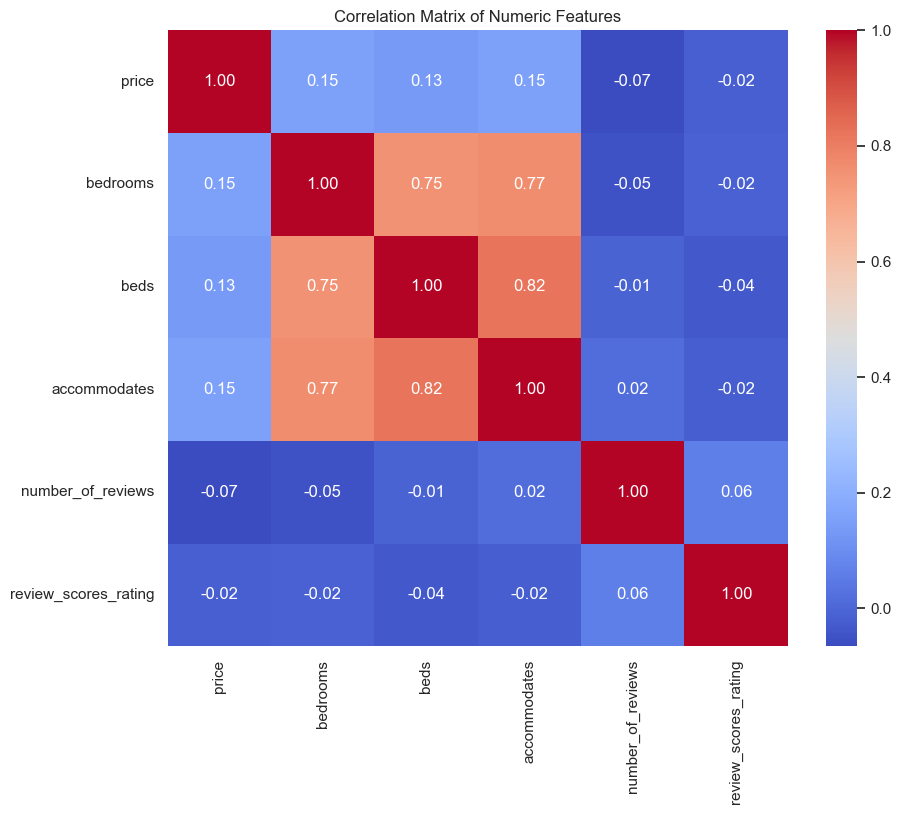

In [1403]:
# correlation heatmap 
numeric_cols = ['price', 'bedrooms', 'beds', 'accommodates', 'number_of_reviews', 'review_scores_rating']
corr_matrix = df_clean[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numeric Features')
plt.show()

In [1404]:
# Amenities 
from collections import Counter
df_clean['amenities_list'] = df_clean['amenities'].str.split(', ')
# Count the frequency of each amenity
amenities_list = [amenity.strip() for sublist in df_clean['amenities_list'] for amenity in sublist if amenity]
amenity_counts = Counter(amenities_list)
most_common_amenities = dict(amenity_counts.most_common(50))

# Plotting the most common amenities
plt.figure(figsize=(12, 8))
# Using the `color` parameter instead of `palette`
sns.barplot(x=list(most_common_amenities.values()), y=list(most_common_amenities.keys()), color='lightblue')
plt.title('Top 10 Most Common Amenities')
plt.xlabel('Frequency')
plt.ylabel('Amenity')

plt.tight_layout()  # Adjust layout
plot_filename_availability = 'top_comon_amenities.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text 
title_text = "Top Comon Amenities"

# Path to the image 
path = 'top_comon_amenities.png'

add_slide_with_title_and_image(prs,title_text,path)


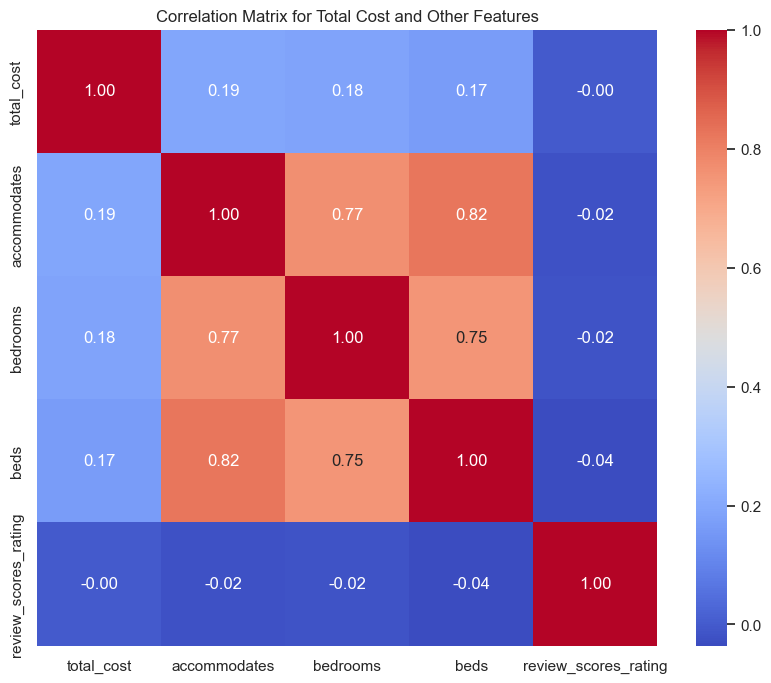

In [1405]:
df_clean['total_cost'] = df_clean['price'] + df_clean['cleaning_fee'].fillna(0) + df_clean['extra_people'].fillna(0)

# Correlation between total cost and other numerical features
correlation_features = ['total_cost', 'accommodates', 'bedrooms', 'beds', 'review_scores_rating']
correlation_matrix = df_clean[correlation_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix for Total Cost and Other Features')
plt.show()

# Scatter plot of total cost vs. accommodates
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_clean, x='accommodates', y='total_cost', alpha=0.6)
plt.title('Total Cost vs. Accommodates')
plt.xlabel('Accommodates')
plt.ylabel('Total Cost')
plt.tight_layout()  # Adjust layout
plot_filename_availability = 'Total_Cost.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline

# Define the title text and position
title_text = "Total Cost Vs. Accommodates"

# Path to the image you want to add
path = 'top_comon_amenities.png'

#slide.shapes.add_picture(img_path_availability, image_left, image_top, width=image_width, height=image_height)

add_slide_with_title_and_image(prs,title_text,path)

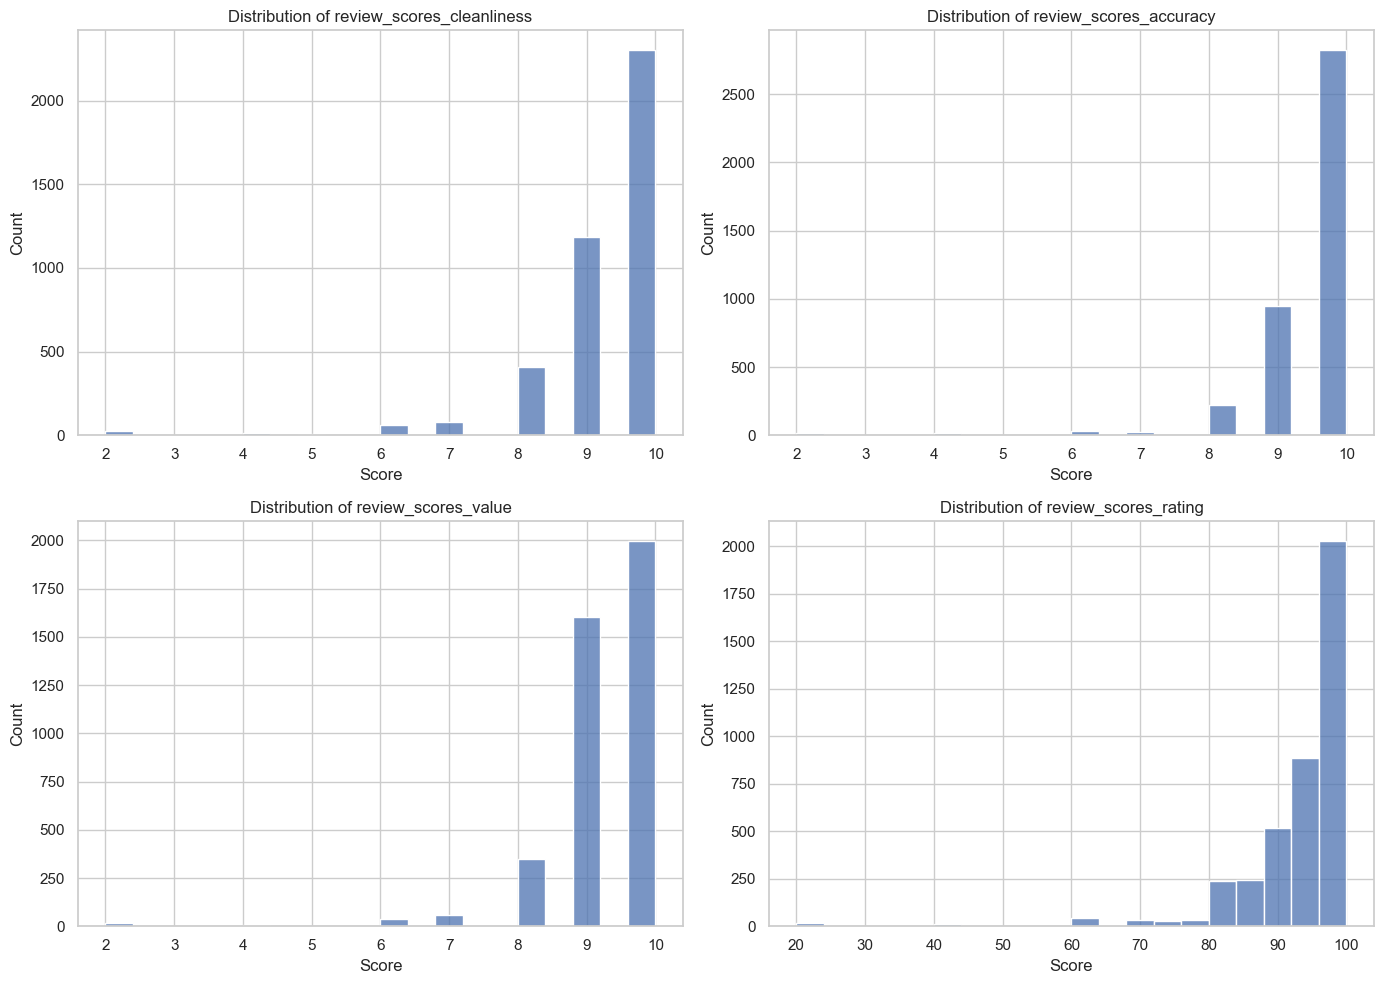

In [1406]:
review_categories = ['review_scores_cleanliness', 'review_scores_accuracy', 'review_scores_value', 'review_scores_rating']

# Distribution of review scores
plt.figure(figsize=(14, 10))
for i, category in enumerate(review_categories, start=1):
    plt.subplot(2, 2, i)
    sns.histplot(df_clean[category], bins=20, kde=False)
    plt.title(f'Distribution of {category}')
    plt.xlabel('Score')
    plt.ylabel('Count')

plt.tight_layout()
#plt.show()

# Correlation between review scores and price/total cost
review_corr_features = review_categories + ['price', 'total_cost']
review_corr_matrix = df_clean[review_corr_features].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(review_corr_matrix, annot=True, cmap='RdYlGn', fmt=".2f")
plt.title('Distribution of Review Scores')

plt.tight_layout()  # Adjust layout
plot_filename_availability = 'Distribution_of_Review_Scores.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
title_text = "Distribution of Review Scores"

# Path to the image 
path = 'Distribution_of_Review_Scores.png'


add_slide_with_title_and_image(prs,title_text,path)

In [1407]:

# Select numeric columns from the DataFrame
numeric_cols = df_clean.select_dtypes(include=['number'])

# Calculate variance for each numeric column
variances = numeric_cols.var()

# Initialize an empty string to capture the formatted output
output_text = "Variance Analysis of Numeric Columns\n\n"

# Format each variance entry with better readability
for column, variance in variances.items():
    output_text += f"- {column.replace('_', ' ').title()} Variance: {variance:.2f}\n"

# Add a slide with the captured text to the presentation
title = "Variance Analysis of Numeric Columns"

add_slide_with_title_and_two_columns(prs, title, output_text)

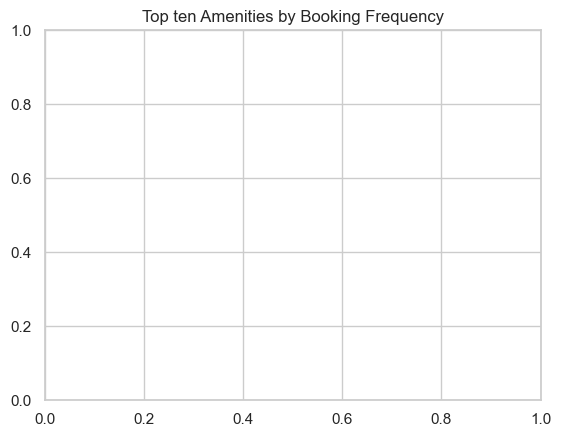

In [1408]:

# Step 1: Convert 'first_review' and 'last_review' to datetime
df_clean['first_review'] = pd.to_datetime(df_clean['first_review'])
df_clean['last_review'] = pd.to_datetime(df_clean['last_review'])

# Step 2: Extract month from 'first_review' and 'last_review'
df_clean['first_review_month'] = df_clean['first_review'].dt.month
df_clean['last_review_month'] = df_clean['last_review'].dt.month

# Step 3: Calculate occupancy rate (as provided)
df_clean['occupancy_rate'] = 1 - (df_clean['availability_availability_365'] / 365)

# Prepare separate DataFrames for first and last review months
df_first = df_clean[['first_review_month', 'occupancy_rate']].rename(columns={'first_review_month': 'month'})
df_last = df_clean[['last_review_month', 'occupancy_rate']].rename(columns={'last_review_month': 'month'})

# Combine the two DataFrames, ignoring NaN values
df_combined = pd.concat([df_first.dropna(), df_last.dropna()])

# Step 5: Group by month and calculate mean occupancy rate
monthly_occupancy = df_combined.groupby('month')['occupancy_rate'].mean().reset_index()

# Step 6: Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=monthly_occupancy, x='month', y='occupancy_rate', marker='o')
plt.title('Occupancy Rate by Month(First and Last Reviews)')
plt.xlabel('Month')
plt.ylabel('Occupancy Rate')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()  # Adjust layout
plot_filename_availability = 'OccupancyRatebyMonthFirstandLastReviews.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
plt.title('Top ten Amenities by Booking Frequency')
# Define the title text 
title_text = "Occupancy Rate by Month (First and Last Reviews"

# Path to the image 
path = 'OccupancyRatebyMonthFirstandLastReviews.png'


add_slide_with_title_and_image(prs,title_text,path)


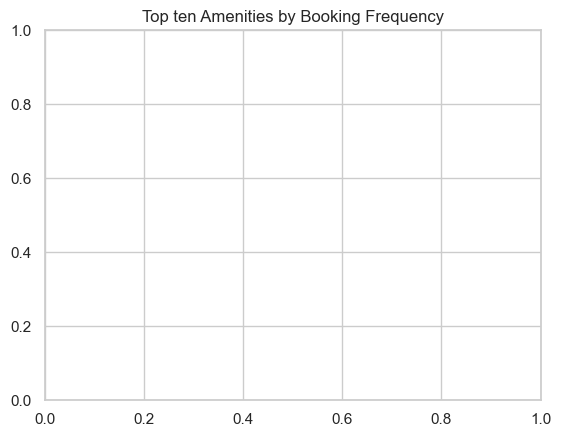

In [1409]:
df_clean['amenities_list'] = df_clean['amenities'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
df_amenities_exploded = df_clean.explode('amenities_list').rename(columns={'amenities_list': 'amenity'})

# Now that each amenity is associated with a listing, calculate the mean number of reviews per amenity
amenity_reviews = df_amenities_exploded.groupby('amenity')['number_of_reviews'].mean().sort_values(ascending=False).head(10)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(y=amenity_reviews.index, x=amenity_reviews.values, color='cyan')
plt.title('Top 10 Amenities by Booking Frequency (Proxy: Number of Reviews)')
plt.xlabel('Average Number of Reviews')
plt.ylabel('Amenity')
plt.tight_layout()  # Adjust layout
plot_filename_availability = 'ToptenAmenitiesbyBookingFrequency.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
plt.title('Top ten Amenities by Booking Frequency')
# Define the title text 
title_text = "Top ten Amenities by Booking Frequency"

# Path to the image 
path = 'ToptenAmenitiesbyBookingFrequency.png'


add_slide_with_title_and_image(prs,title_text,path)

In [1410]:
df_clean['first_review_date'] = pd.to_datetime(df_clean['first_review'], unit='ms')
df_clean['last_review_date'] = pd.to_datetime(df_clean['last_review'], unit='ms')

# Extracting city and country
df_clean['city'] = df_clean['address'].apply(lambda x: x['street'].split(',')[0])  # Simplistic extraction, adjust as needed
df_clean['country'] = df_clean['address'].apply(lambda x: x['country'])

# Selecting relevant columns to display
df_final = df_clean[['city', 'country', 'first_review_date', 'last_review_date']]

print(df_final)

                city        country   first_review_date    last_review_date
0              Porto       Portugal 2016-01-03 05:00:00 2019-01-20 05:00:00
1     Rio de Janeiro         Brazil                 NaT                 NaT
2           Honolulu  United States 2013-05-24 04:00:00 2019-02-07 05:00:00
3           Brooklyn  United States 2016-01-31 05:00:00 2016-01-31 05:00:00
4     Rio de Janeiro         Brazil                 NaT                 NaT
...              ...            ...                 ...                 ...
5550           Porto       Portugal 2016-01-03 05:00:00 2019-02-07 05:00:00
5551         Kadıköy         Turkey                 NaT                 NaT
5552  Rio de Janeiro         Brazil 2016-01-06 05:00:00 2019-01-27 05:00:00
5553         Lahaina  United States 2015-08-17 04:00:00 2018-08-06 04:00:00
5554         Lahaina  United States 2016-04-06 04:00:00 2018-08-20 04:00:00

[5555 rows x 4 columns]


In [1411]:
print("Columns in DataFrame:", df_final.columns)
#city_distribution = df['city'].value_counts()

# Display the distribution
#print(city_distribution)

Columns in DataFrame: Index(['city', 'country', 'first_review_date', 'last_review_date'], dtype='object')


In [1412]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the visual style of the plots
sns.set(style="whitegrid")

# Plotting the distribution of listings across cities
plt.figure(figsize=(10, 8))
city_distribution = df_final['city'].value_counts().nlargest(10)  # You might want to limit to the top 10 cities for clarity
sns.barplot(x=city_distribution.values, y=city_distribution.index, palette="coolwarm")
plt.title('Distribution of Listings Across Cities')
plt.xlabel('Number of Listings')
plt.ylabel('City')
plt.tight_layout()  # Adjust layout
plot_filename_availability = 'DistributionofListingsAcrossCities.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
title_text = "Distribution of Listings Across Cities"

# Path to the image 
path = 'DistributionofListingsAcrossCities.png'


add_slide_with_title_and_image(prs,title_text,path)

/var/folders/h1/_7xrrb6901zclwx0hy1h5vh40000gn/T/ipykernel_22296/366029228.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=city_distribution.values, y=city_distribution.index, palette="coolwarm")


In [1413]:
highest_total_cost_record = df_clean[df_clean['total_cost'] == df_clean['total_cost'].max()]

# Display the record
print(highest_total_cost_record)

           _id                            listing_url  \
1954  20275354  https://www.airbnb.com/rooms/20275354   

                                                   name  \
1954  İstanbul un kalbi sisli. Center of istanbul sisli   

                                                summary  \
1954  We are new married couple.We have have one ful...   

                                                  space  \
1954  our flat which is located in Sisli Bomonti jus...   

                                            description  \
1954  We are new married couple.We have have one ful...   

                         neighborhood_overview notes transit access  ...  \
1954  Safe and good located gay freindly area.                       ...   

     review_scores_rating                                     amenities_list  \
1954                  NaN  [TV, Cable TV, Wifi, Kitchen, Smoking allowed,...   

     total_cost first_review_month last_review_month occupancy_rate  \
1954    48842.0         

In [1414]:


df_clean['price'] = pd.to_numeric(df_clean['price'], errors='coerce')
df_clean['extra_people'] = pd.to_numeric(df_clean['extra_people'], errors='coerce')

# Calculate total cost including extra people fee
df_clean['total_cost_including_extra'] = df_clean['price'] + df_clean['extra_people'].fillna(0)
sns.scatterplot(data=df_clean, x='accommodates', y='total_cost_including_extra', alpha=0.6)
plt.title('Price vs. Accommodates Including Extra People Fee')
plt.xlabel('Accommodates')
plt.ylabel('Total Cost Including Extra People Fee')
plt.tight_layout()  # Adjust layout
plot_filename_availability = 'PriceAccommodatesIncludingExtraPeopleFee.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
title_text = "Price vs. Accommodates Including Extra People Fee"

# Path to the image 
path = 'PriceAccommodatesIncludingExtraPeopleFee.png'


add_slide_with_title_and_image(prs,title_text,path)

In [1415]:
df_clean_filtered = df_clean.loc[df_clean['_id'] != 20275354]

In [1416]:
sorted_df = df_clean[['price', '_id']].sort_values(by='price', ascending=True)

# Display the sorted DataFrame
print(sorted_df)

        price       _id
873       9.0  14758068
4123     10.0  31305846
2018     10.0  20611485
4391     10.0  32636126
2839     12.0  24450419
...       ...       ...
3927  10001.0  30327756
737   11190.0  13997910
3391  11681.0  27593455
860   11681.0  14644562
1954  48842.0  20275354

[5555 rows x 2 columns]


In [1417]:
df_clean['_id'] = df_clean['_id'].astype(str)

# Filter out the record with _id '20275354'
df_clean_filtered = df_clean.loc[df_clean['_id'] != '20275354']

In [1418]:
sorted_df = df_clean_filtered[['price', '_id']].sort_values(by='price', ascending=True)

# Display the sorted DataFrame
print(sorted_df)

        price       _id
873       9.0  14758068
4391     10.0  32636126
4123     10.0  31305846
2018     10.0  20611485
2839     12.0  24450419
...       ...       ...
3927  10001.0  30327756
2386  10001.0  22200454
737   11190.0  13997910
3391  11681.0  27593455
860   11681.0  14644562

[5554 rows x 2 columns]


In [1419]:
# Filter listings with zero bedrooms
zero_bedroom_listings = df_clean[df_clean['bedrooms'] == 0]

# Count the number of listings with zero bedrooms
num_zero_bedroom_listings = zero_bedroom_listings.shape[0]

# Display the count
print(f"Number of listings with zero bedrooms: {num_zero_bedroom_listings}")

# If you also want to see the prices of these listings:
print("Prices of listings with zero bedrooms:")
print(zero_bedroom_listings['price'])

Number of listings with zero bedrooms: 0
Prices of listings with zero bedrooms:
Series([], Name: price, dtype: float64)


In [1420]:
zero_bed_listings = df_clean[df_clean['beds'] == 0]

# Count the number of listings with zero beds
num_zero_bed_listings = zero_bed_listings.shape[0]

# Display the count
print(f"Number of listings with zero beds: {num_zero_bed_listings}")

# If you want to see the prices of these listings:
print("Prices of listings with zero beds:")
print(zero_bed_listings['price'])

average_price_by_beds = df_clean.groupby('beds')['price'].mean()

# Display the average prices
print("Average price by number of beds:")
print(average_price_by_beds)

Number of listings with zero beds: 29
Prices of listings with zero beds:
100     135.0
318      99.0
396      42.0
620     119.0
740     486.0
787      70.0
830     200.0
857      40.0
996      78.0
1166    194.0
1317    109.0
1450    469.0
1499    125.0
1605    350.0
1869     86.0
1974     45.0
2159     68.0
2208    125.0
2568    200.0
2625    148.0
3295    200.0
3731    119.0
4004    140.0
4025    210.0
4471    127.0
4474    105.0
4670     80.0
4789    136.0
4987    150.0
Name: price, dtype: float64
Average price by number of beds:
beds
0.0      153.620690
1.0      216.449687
2.0      234.272991
3.0      358.929985
4.0      408.410390
5.0      544.891566
6.0      598.816514
7.0      768.860465
8.0      586.714286
9.0      495.545455
10.0     719.937500
11.0     621.333333
12.0     251.800000
13.0     320.000000
14.0     240.500000
15.0    2929.500000
16.0    1291.500000
18.0    5502.000000
25.0     227.000000
Name: price, dtype: float64


In [1421]:
grouped_data = df_clean.groupby(['city', 'property_type', 'beds'])['price'].mean().reset_index()

# Display the first few rows of the grouped data
print(grouped_data.head())
specific_data = grouped_data[(grouped_data['city'] == 'Barcelona') & (grouped_data['property_type'] == 'Apartment')]

# Visualize the relationship between number of beds and average price
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.lineplot(data=specific_data, x='beds', y='price', marker='o')
plt.title('Average Price by Number of Beds in SpecificCity for Houses')
plt.xlabel('Number of Beds')
plt.ylabel('Average Price')
plt.tight_layout()  # Adjust layout
plot_filename_availability = 'AveragePricebyNumberofBeds.png'
plt.savefig(plot_filename_availability, bbox_inches='tight')  # Save the plot
plt.close()  # Close the plot to prevent displaying it inline
# Define the title text 
title_text = "Average Price by Number of Beds in Houses"

# Path to the image 
path = 'AveragePricebyNumberofBeds.png'


add_slide_with_title_and_image(prs,title_text,path)

     city      property_type  beds   price
0  ADALAR  Bed and breakfast   1.0  2979.0
1  Adalar          Apartment   1.0   169.0
2  Adalar          Apartment   3.0   169.0
3  Adalar             Chalet   4.0   401.0
4  Adalar       Nature lodge   1.0   100.0


In [1422]:
columns_of_interest = ['review_scores_accuracy', 'review_scores_cleanliness', 
                       'review_scores_checkin', 'review_scores_communication', 
                       'review_scores_location', 'review_scores_value', 
                       'price', 'cleaning_fee', 'bathrooms']

# Calculate correlation matrix
correlation_matrix = df_clean[columns_of_interest].corr()

# Display the correlation matrix
print(correlation_matrix)

                             review_scores_accuracy  \
review_scores_accuracy                     1.000000   
review_scores_cleanliness                  0.664999   
review_scores_checkin                      0.631432   
review_scores_communication                0.646412   
review_scores_location                     0.496290   
review_scores_value                        0.723412   
price                                     -0.058196   
cleaning_fee                               0.037874   
bathrooms                                  0.017731   

                             review_scores_cleanliness  review_scores_checkin  \
review_scores_accuracy                        0.664999               0.631432   
review_scores_cleanliness                     1.000000               0.535909   
review_scores_checkin                         0.535909               1.000000   
review_scores_communication                   0.541829               0.715857   
review_scores_location                      

In [1423]:
# Initialize an empty string to capture the output with a heading
output_text = "Review Scores Analysis\n\n"

# Add a subheading for the first set of columns
output_text += "Review Scores Breakdown:\n"

# First set of columns
review_score_columns = ['review_scores_accuracy', 'review_scores_cleanliness', 
                        'review_scores_checkin', 'review_scores_communication', 
                        'review_scores_location', 'review_scores_value']

for column in review_score_columns:
    more_than_8 = (df_clean[column] > 8.0).sum()
    less_than_5 = (df_clean[column] < 5.0).sum()
    output_text += f"- {column.replace('_', ' ').title()}:\n    More than 8.0: {more_than_8}\n    Less than 5.0: {less_than_5}\n"

# Add a subheading for the 'beds' column
output_text += "\nBeds Score Analysis:\n"

# Second set for 'beds' column
review_score_columns = ['beds']

for column in review_score_columns:
    more_than_7 = (df_clean[column] > 7.0).sum()
    less_than_9 = (df_clean[column] < 9.0).sum()
    output_text += f"- {column.title()}:\n    More than 7.0: {more_than_7}\n    Less than 9.0: {less_than_9}\n"


# Use the function to add this content to the presentation
add_slide_with_title_and_two_columns(prs, "Review Scores and Beds Analysis", output_text)



In [1424]:
# Add a blank slide layout (usually layout 6 is blank, but this can vary)
slide_layout = prs.slide_layouts[1]  # Title and Content layout
slide = prs.slides.add_slide(slide_layout)
title_shape = slide.shapes.title
title_shape.text = "DATA"



# Center the title
for paragraph in title_shape.text_frame.paragraphs:
    paragraph.alignment = PP_ALIGN.CENTER

# Set the font size for the title
for run in title_shape.text_frame.paragraphs[0].runs:
    run.font.size = Pt(44)  # Example size, adjust as needed

# Add bullet points
txBox = slide.shapes.add_textbox(Inches(2), Inches(2), Inches(6), Inches(4))
tf = txBox.text_frame

# Text to add as bullet points
points = [
    "Numeric data has different formats like dictionary.",
    "Several data elements like datetime need to be transformed.",
    "There are several numeric fields have null or NaN values in it.",
    "Flattening is required in some cases."
]

for point in points:
    p = tf.add_paragraph()
    p.text = point
    p.space_after = Inches(0.1)
    # Center the bullet points
    p.alignment = PP_ALIGN.LEFT


In [1425]:
# Add another blank slide
slide_layout = prs.slide_layouts[1]  # Title and Content layout
slide = prs.slides.add_slide(slide_layout)
title_shape = slide.shapes.title
title_shape.text = "Cleaning up"
# Center the title
for paragraph in title_shape.text_frame.paragraphs:
    paragraph.alignment = PP_ALIGN.CENTER

# Set the font size for the title if necessary
# Adjust the font size according to your needs
for run in title_shape.text_frame.paragraphs[0].runs:
    run.font.size = Pt(44)  # Example size, adjust as needed

# Add bullet points for the new slide
txBox = slide.shapes.add_textbox(Inches(2), Inches(2), Inches(6), Inches(4))
tf = txBox.text_frame

# Text to add as bullet points for the new slide
points = [
    "Wrote a transform function to transform.",
    "transformed and flattened numeric and decimal fields",
    "Flattened availability, scores, address fields."
]

for point in points:
    p = tf.add_paragraph()
    p.text = point
    p.space_after = Inches(0.1)
    # Align the bullet points to the left
    p.alignment = PP_ALIGN.LEFT

In [1426]:
savePPT(prs)

Presentation saved successfully.
